In [1]:
#importing the libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import librosa

from IPython.display import display, Audio
from pydub import AudioSegment

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector

from keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate
from keras.models import Sequential
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings(action="ignore")

C:\Users\DrdrA\AppData\Roaming\Python\Python311\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
#importing all 380,000 data entries to one file for treatment
file_paths = [
    "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-train.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-other-train.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-invalid.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-dev.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-other-dev.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-test.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-other-test.csv",
]
dfs = []
for i in file_paths:
    df = pd.read_csv(i)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380368 entries, 0 to 380367
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   filename    380368 non-null  object 
 1   text        380366 non-null  object 
 2   up_votes    380368 non-null  int64  
 3   down_votes  380368 non-null  int64  
 4   age         149021 non-null  object 
 5   gender      149281 non-null  object 
 6   accent      129234 non-null  object 
 7   duration    0 non-null       float64
dtypes: float64(1), int64(2), object(5)
memory usage: 23.2+ MB


In [4]:
#finding how many null values there are
print(df.isna().sum())

filename           0
text               2
up_votes           0
down_votes         0
age           231347
gender        231087
accent        251134
duration      380368
dtype: int64


In [5]:
#removing all lines without age value
df = df.dropna(subset=['age'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149021 entries, 5 to 380366
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   filename    149021 non-null  object 
 1   text        149020 non-null  object 
 2   up_votes    149021 non-null  int64  
 3   down_votes  149021 non-null  int64  
 4   age         149021 non-null  object 
 5   gender      148487 non-null  object 
 6   accent      126628 non-null  object 
 7   duration    0 non-null       float64
dtypes: float64(1), int64(2), object(5)
memory usage: 10.2+ MB


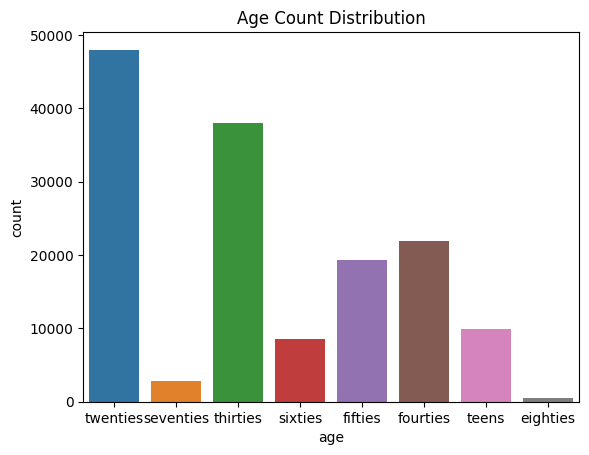

In [6]:
#visualizing the data before treatment
plt.title("Age Count Distribution")
sns.countplot(x=df.age)
plt.show()

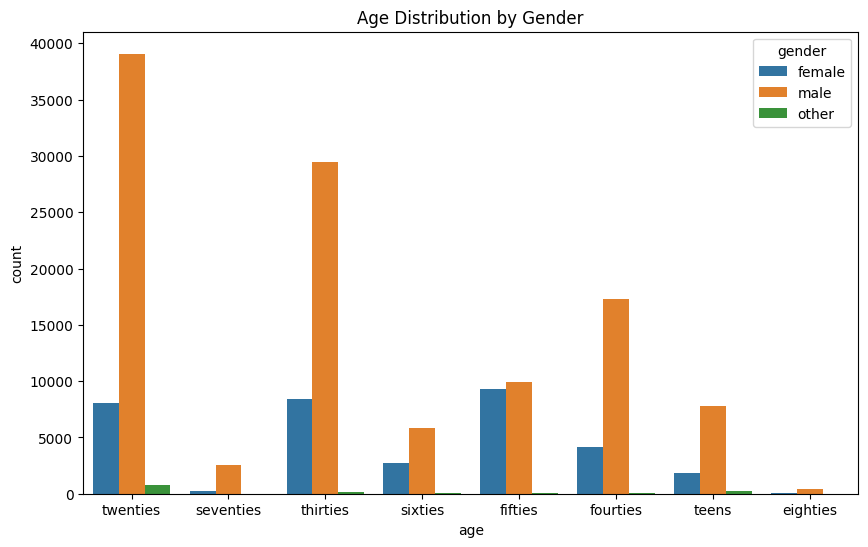

In [7]:
plt.figure(figsize=(10, 6))
plt.title("Age Distribution by Gender")
sns.countplot(x='age', hue='gender', data=df)
plt.show()

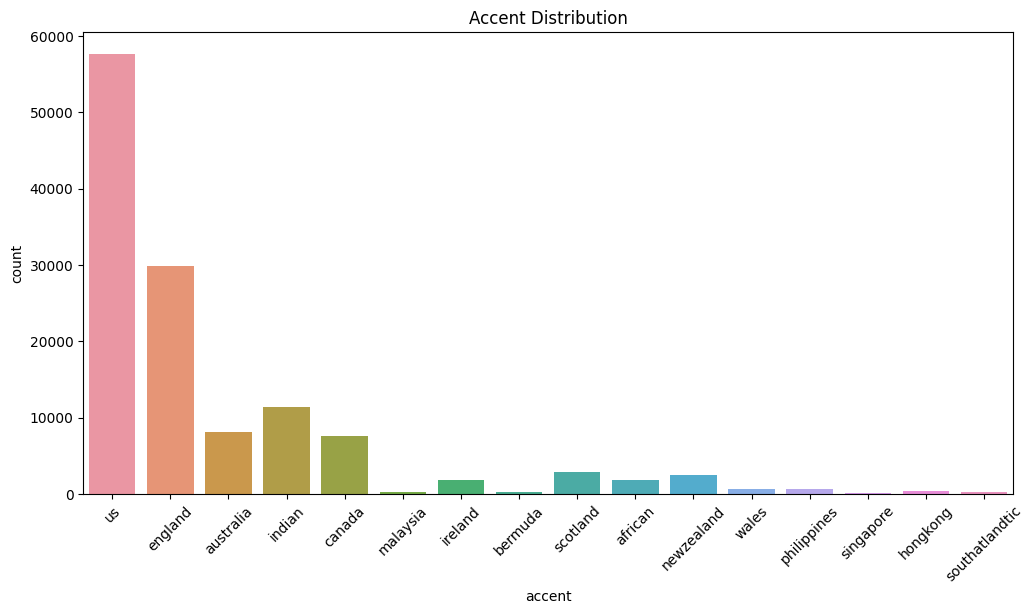

In [8]:
plt.figure(figsize=(12, 6))
plt.title("Accent Distribution")
sns.countplot(x='accent', data=df)
plt.xticks(rotation=45)
plt.show()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149021 entries, 5 to 380366
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   filename    149021 non-null  object 
 1   text        149020 non-null  object 
 2   up_votes    149021 non-null  int64  
 3   down_votes  149021 non-null  int64  
 4   age         149021 non-null  object 
 5   gender      148487 non-null  object 
 6   accent      126628 non-null  object 
 7   duration    0 non-null       float64
dtypes: float64(1), int64(2), object(5)
memory usage: 10.2+ MB


In [10]:
#removing unecessary columns and null values from either gender or accent column
#keeping text to see if it would affect the model's performance first
df = df[["filename","age","gender","accent"]]
df = df.dropna(subset=['gender'])
df = df.dropna(subset=['accent'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126108 entries, 5 to 380361
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  126108 non-null  object
 1   age       126108 non-null  object
 2   gender    126108 non-null  object
 3   accent    126108 non-null  object
dtypes: object(4)
memory usage: 4.8+ MB


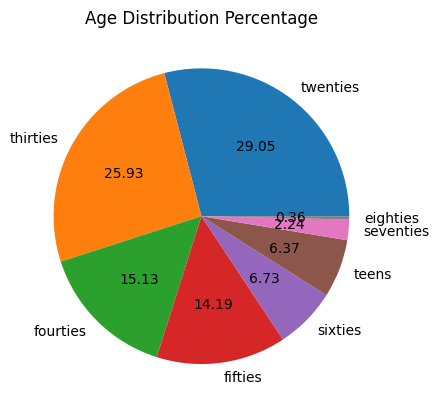

In [11]:
# Visualisation After Treatment
plt.title("Age Distribution Percentage")
plt.pie(df.age.value_counts().values,labels=df.age.value_counts().index,autopct="%0.2f")
plt.show()

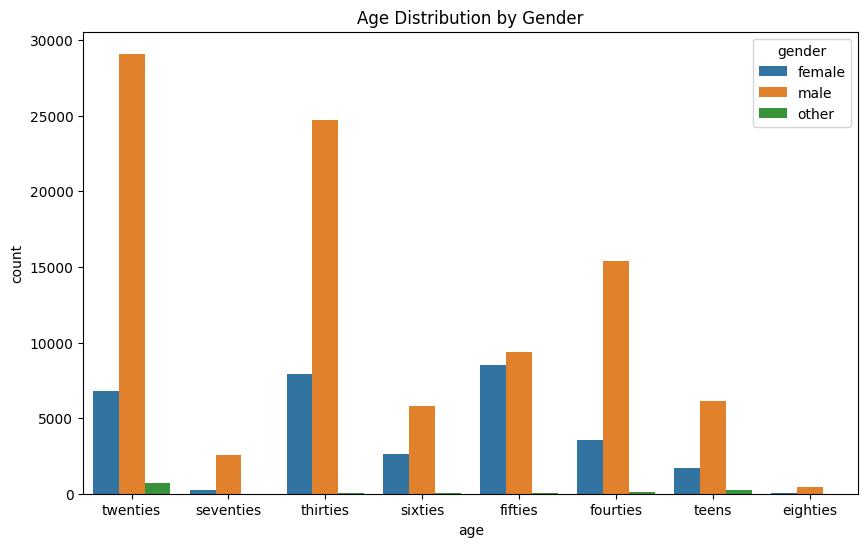

In [12]:
plt.figure(figsize=(10, 6))
plt.title("Age Distribution by Gender")
sns.countplot(x='age', hue='gender', data=df)
plt.show()

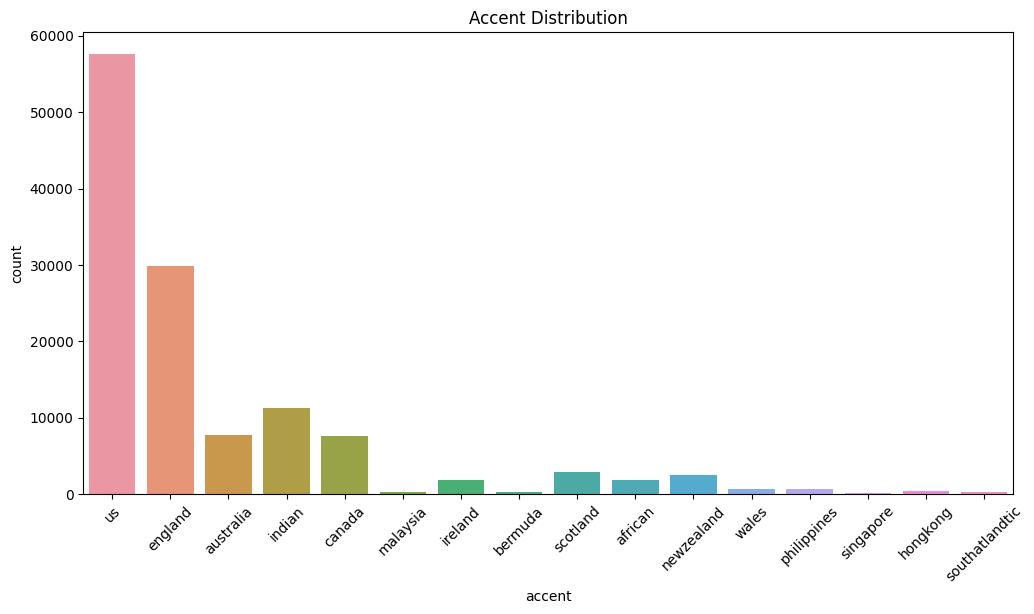

In [13]:
plt.figure(figsize=(12, 6))
plt.title("Accent Distribution")
sns.countplot(x='accent', data=df)
plt.xticks(rotation=45)
plt.show()

In [14]:
# Convert 'age' column to numerical
#Numeric data is more efficient for a computer to process +
#Neural networks work with numeric data and may not support categorical data
cleanup_nums = {"age": {"teens":1,"twenties":2,"thirties":3,"fourties":4,"fifties":5,"sixties":6,"seventies":7,"eighties":8}}
df = df.replace(cleanup_nums)
df.head(3)

,filename,age,gender,accent
5,cv-valid-train/sample-000005.mp3,2,female,us
8,cv-valid-train/sample-000008.mp3,7,male,us
13,cv-valid-train/sample-000013.mp3,3,female,us


In [15]:
#Convert categorical variables to numerical using one-hot encoding
df = pd.get_dummies(df, columns=['gender', 'accent'])
df.head(3)

,filename,age,gender_female,gender_male,gender_other,accent_african,accent_australia,accent_bermuda,accent_canada,accent_england,...,accent_indian,accent_ireland,accent_malaysia,accent_newzealand,accent_philippines,accent_scotland,accent_singapore,accent_southatlandtic,accent_us,accent_wales
5,cv-valid-train/sample-000005.mp3,2,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
8,cv-valid-train/sample-000008.mp3,7,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
13,cv-valid-train/sample-000013.mp3,3,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126108 entries, 5 to 380361
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   filename               126108 non-null  object
 1   age                    126108 non-null  int64 
 2   gender_female          126108 non-null  bool  
 3   gender_male            126108 non-null  bool  
 4   gender_other           126108 non-null  bool  
 5   accent_african         126108 non-null  bool  
 6   accent_australia       126108 non-null  bool  
 7   accent_bermuda         126108 non-null  bool  
 8   accent_canada          126108 non-null  bool  
 9   accent_england         126108 non-null  bool  
 10  accent_hongkong        126108 non-null  bool  
 11  accent_indian          126108 non-null  bool  
 12  accent_ireland         126108 non-null  bool  
 13  accent_malaysia        126108 non-null  bool  
 14  accent_newzealand      126108 non-null  bool  
 15  accen

In [17]:
df['age'].value_counts()

age
2    36631
3    32695
4    19082
5    17895
6     8486
1     8039
7     2830
8      450
Name: count, dtype: int64

In [18]:
df.head(2)

,filename,age,gender_female,gender_male,gender_other,accent_african,accent_australia,accent_bermuda,accent_canada,accent_england,...,accent_indian,accent_ireland,accent_malaysia,accent_newzealand,accent_philippines,accent_scotland,accent_singapore,accent_southatlandtic,accent_us,accent_wales
5,cv-valid-train/sample-000005.mp3,2,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
8,cv-valid-train/sample-000008.mp3,7,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [20]:
#extract features
#Spectral Centroid + Spectral Bandwidth + Spectral Rolloff + MFCCs
folder_path = "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-train/"

def feature_extraction(filename, sampling_rate=48000):
    path = "{}{}".format(folder_path, filename)
    features = list()
    audio, _ = librosa.load(path, sr=sampling_rate)
    
    # Extract age label from DataFrame based on filename
    age = df[df['filename'] == filename].age.values[0]
    
    # Feature extraction
    features.append(age)
    features.append(np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate)))
    features.append(np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate)))
    features.append(np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate)))
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate)
    for el in mfcc:
        features.append(np.mean(el))
    
    return features

# Extract features for all files in all folder paths
features = feature_extraction(df.iloc[0]['filename'])
print("features: ", features)

features:  [2, 2147.6058803589067, 2430.474971192408, 4428.830553016453, -625.28143, 111.306145, 6.3690844, 34.7671, 31.623457, -4.721564, -0.5119338, -4.9454904, -12.71285, -2.0436711, -3.7277248, -10.708405, -11.206564, -12.003516, -8.506438, -5.472296, -4.950396, -3.7100525, -6.3149858, -6.3280854]


In [21]:
#the function create dataframe to store the feature and label related to each other
def create_df_features(orig):
    new_rows = list()
    tot_rows = len(orig)-1
    stop_counter = 55001
    
    for idx, row in orig.iterrows():
        if idx >= stop_counter: break
        print("\r", end="")
        print("{}/{}".format(idx, tot_rows), end="", flush=True)
        features = feature_extraction(row['filename'])
        #features.append(row['age']) #label is age
        new_rows.append(features)

    return pd.DataFrame(new_rows, columns=["label", "spectral_centroid", "spectral_bandwidth", "spectral_rolloff",
                                    "mfcc1", "mfcc2", "mfcc3", "mfcc4", "mfcc5", "mfcc6", "mfcc7", "mfcc8",
                                   "mfcc9", "mfcc10", "mfcc11", "mfcc12", "mfcc13", "mfcc14", "mfcc15", "mfcc16",
                                   "mfcc17", "mfcc18", "mfcc19", "mfcc20", "age"])

df_features = create_df_features(df)
df_features.head()

54998/126107

,label,spectral_centroid,spectral_bandwidth,spectral_rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,age
0,2,2147.605880,2430.474971,4428.830553,-625.281433,111.306145,6.369084,34.767101,31.623457,-4.721564,...,-10.708405,-11.206564,-12.003516,-8.506438,-5.472296,-4.950396,-3.710052,-6.314986,-6.328085,2
1,7,2815.325440,2451.922347,4884.633819,-469.936646,126.283386,-16.548649,3.546792,2.184188,13.748076,...,-10.987889,1.132519,6.090083,-1.732454,-1.226424,-6.432128,-7.269326,-4.796600,-3.129156,7
2,3,1844.637736,1491.011525,3164.948048,-418.205475,147.666870,-49.974003,-2.286364,37.185310,-8.906048,...,-13.844883,-9.928527,-7.873624,-5.476490,-2.298846,-6.556987,-5.206552,-0.403855,-3.877070,3
3,6,2123.711334,2202.012929,4111.215965,-464.910706,118.437225,19.749662,27.143229,26.438824,2.309232,...,-5.461425,-2.908412,-4.496074,-2.716447,-0.080573,-5.294940,-5.868721,0.600507,-3.375833,6
4,5,2360.672043,2957.220239,4767.080050,-343.833008,157.153885,7.661150,41.898964,-15.152473,28.925110,...,0.102648,6.319802,-1.603871,3.837120,-2.643298,2.323319,-1.382684,3.791498,-3.534383,5


In [22]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17714 entries, 0 to 17713
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   label               17714 non-null  int64  
 1   spectral_centroid   17714 non-null  float64
 2   spectral_bandwidth  17714 non-null  float64
 3   spectral_rolloff    17714 non-null  float64
 4   mfcc1               17714 non-null  float32
 5   mfcc2               17714 non-null  float32
 6   mfcc3               17714 non-null  float32
 7   mfcc4               17714 non-null  float32
 8   mfcc5               17714 non-null  float32
 9   mfcc6               17714 non-null  float32
 10  mfcc7               17714 non-null  float32
 11  mfcc8               17714 non-null  float32
 12  mfcc9               17714 non-null  float32
 13  mfcc10              17714 non-null  float32
 14  mfcc11              17714 non-null  float32
 15  mfcc12              17714 non-null  float32
 16  mfcc